# Single RNA-seq to Spatial RNA-seq

Single2Spatial is used for scRNA-seq transformat to stRNA-seq. We extracted the deep-forest part of the Bulk2Space algorithm and constructed an algorithm that can calculate the spatial RNA-seq from scRNA-seq. In addition, we have redesigned the input and output of the data so that it can be more compatible with the analysis conventions in the Python environment.

Paper: [De novo analysis of bulk RNA-seq data at spatially resolved single-cell resolution](https://www.nature.com/articles/s41467-022-34271-z)

Code: https://github.com/ZJUFanLab/bulk2space

Colab_Reproducibility：https://colab.research.google.com/drive/1E3TlGUW2bxEew8JYCLE9qA6saYbIjBnY?usp=sharing

This tutorial walks through how to read, set-up and train the model from scRNA-seq and reference stRNA-seq data. We use the pdac datasets as example

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import omicverse as ov
import matplotlib.pyplot as plt

ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 04日 星期一 17:03:21 CST


## loading data

Single2Spatial calcualted the the spot of celltype in spatial RNA-seq from scRNA-seq by deep-forest tree, we need an average normalize, log and scale the expression matrix of scRNA-seq, 

We also need an anndata object of stRNA-seq as reference to calculate. The data can be downloaded from [here](https://drive.google.com/file/d/1xB-Gk_KLxQA320-tycJp4CFHA66zF3LE/view?usp=sharing). The processed the PDAC scRNA-seq data and ST data (GSE111672)

In [3]:
import anndata
raw_data=pd.read_csv('data/pdac/sc_data.csv', index_col=0)
single_data=anndata.AnnData(raw_data.T)
single_data.obs = pd.read_csv('data/pdac/sc_meta.csv', index_col=0)[['Cell_type']]
single_data

AnnData object with n_obs × n_vars = 1926 × 19104
    obs: 'Cell_type'

In [4]:
raw_data=pd.read_csv('data/pdac/st_data.csv', index_col=0)
spatial_data=anndata.AnnData(raw_data.T)
spatial_data.obs = pd.read_csv('data/pdac/st_meta.csv', index_col=0)
spatial_data

AnnData object with n_obs × n_vars = 428 × 19104
    obs: 'Spot', 'xcoord', 'ycoord'

## set up, training, saving, and loading

We can now set up the Single2Spatial object, which will ensure everything the model needs is in place for training. We need to specify the cell type of the scRNA-seq and the spot_key of the stRNA-seq. And specify the number of marker genes for each cell type for training.

In [5]:
st_model=ov.bulk2single.Single2Spatial(single_data=single_data,
                                           spatial_data=spatial_data,
                                           celltype_key='Cell_type',
                                           spot_key=['xcoord','ycoord'],
                                           #gpu='mps',
                                          )

...loading data


Now we can start to train our Single2Spatial model.


In [6]:
%%time
sp_adata=st_model.train(spot_num=500,
                cell_num=10,
                df_save_dir='data/pdac/predata_net/save_model',
                df_save_name='pdac_df',
                k=10,num_epochs=1000,batch_size=1000,predicted_size=32)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)
sucessfully create positive data
sucessfully create negative data
select top 500 marker genes of each cell type...
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)
...The model size is 14478
...Net training


Epoch [1000/1000], Loss: 0.5751: 100%|██████████| 1000/1000 [01:46<00:00,  9.40it/s]


...Net training done!
...save trained net in data/pdac/predata_net/save_model/pdac_df.pth.
Calculating scores...


Now calculating scores for spot 428/428: 100%|██████████| 14/14 [03:36<00:00, 15.45s/it]


Calculating scores done.
...save trained net in data/pdac/predata_net/save_model/pdac_df.pth.
CPU times: user 6min 50s, sys: 4min 17s, total: 11min 8s
Wall time: 8min 28s


We can also load our previously trained model directly

In [7]:
%%time
sp_adata=st_model.load(modelsize=14478,df_load_dir='data/pdac/predata_net/save_model/pdac_df.pth',
                k=10,predicted_size=32)

select top 500 marker genes of each cell type...
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)
Calculating scores...


Now calculating scores for spot 428/428: 100%|██████████| 14/14 [03:50<00:00, 16.46s/it]


Calculating scores done.
CPU times: user 6min 35s, sys: 4min 7s, total: 10min 43s
Wall time: 6min 22s


## Investigate deconvolution results at spot-level resolution

We also evaluated the spatial deconvolution results at spot-level resolution. We firstly calculated cell type proportion per spot and then aggregated gene expression of cells per spot.

In [8]:
sp_adata_spot=st_model.spot_assess()

## Plot spatial expression patterns of marker genes with single cell resolution

The spatial expression patterns of marker genes were also consistent with the spatial distribution of cell types.

[<Axes: title={'center': 'REG1A'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'CLDN1'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'KRT16'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'MUC5B'}, xlabel='X_spatial1', ylabel='X_spatial2'>]

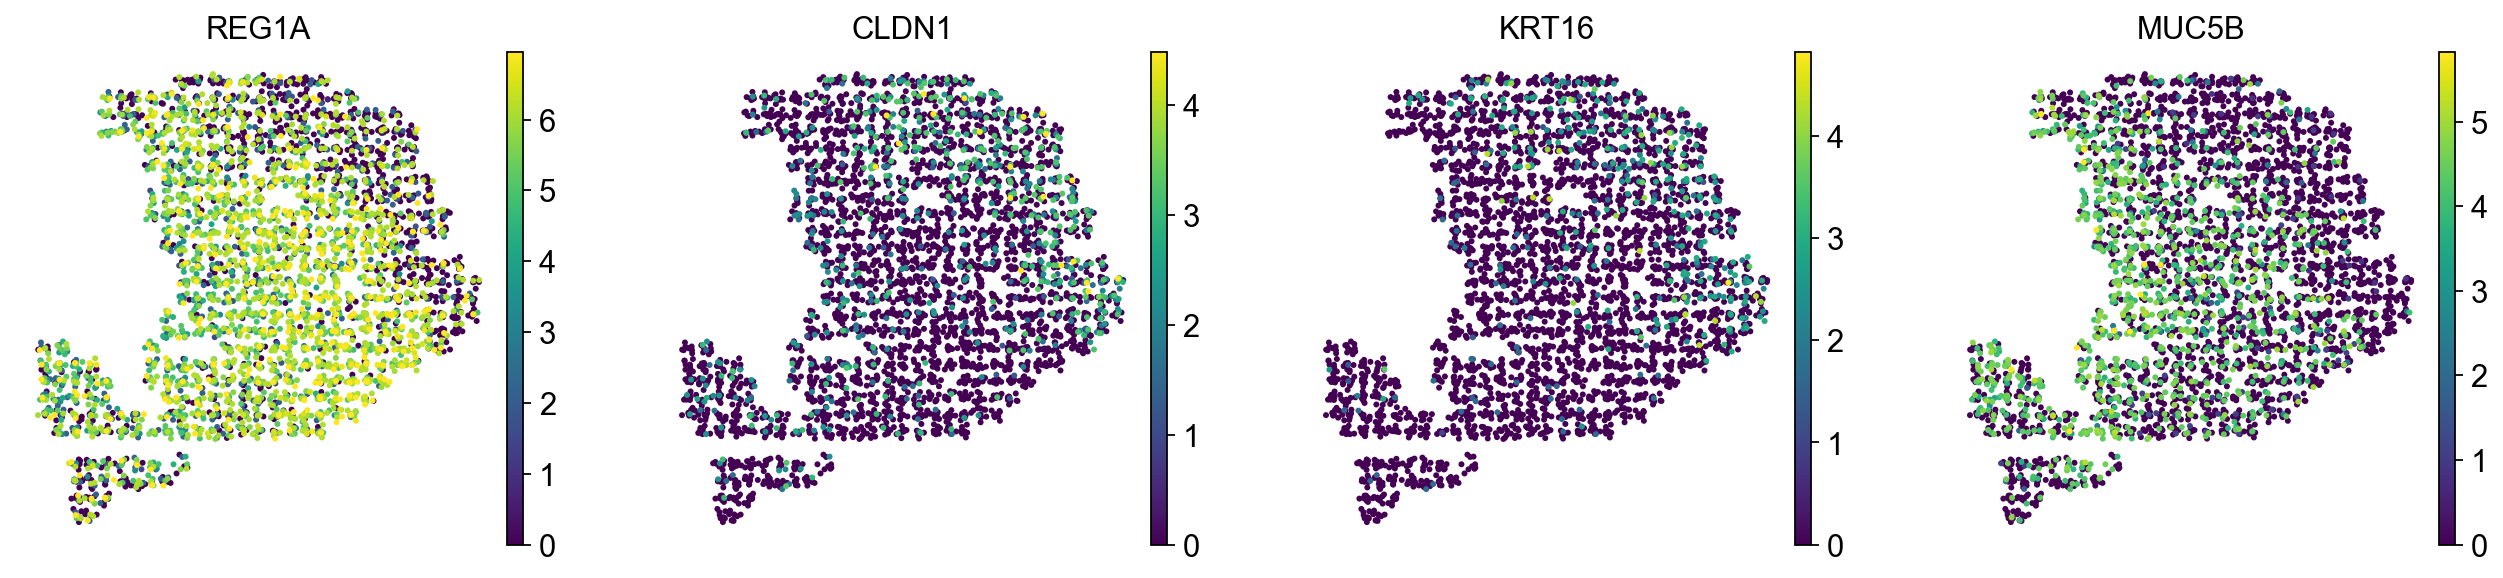

In [9]:
sc.pl.embedding(
    sp_adata,
    basis="X_spatial",
    color=['REG1A', 'CLDN1', 'KRT16', 'MUC5B'],
    frameon=False,
    ncols=4,
    #save='_figure1_gene.png',
    show=False,
)

We also can plot gene in spot level

[<Axes: title={'center': 'REG1A'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'CLDN1'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'KRT16'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'MUC5B'}, xlabel='X_spatial1', ylabel='X_spatial2'>]

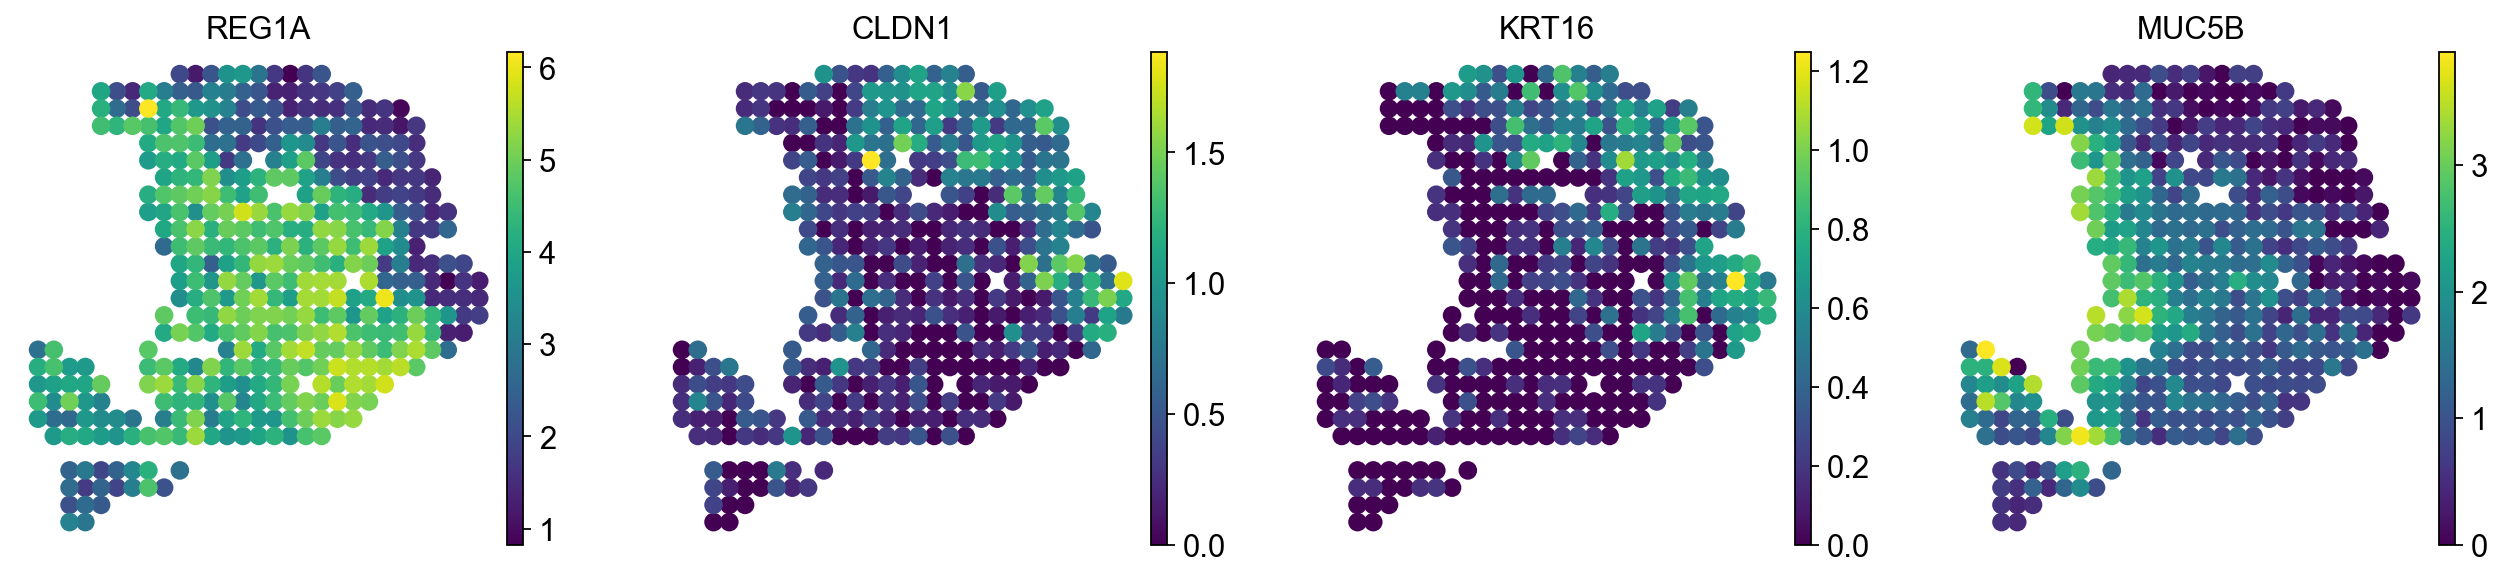

In [10]:
sc.pl.embedding(
    sp_adata_spot,
    basis="X_spatial",
    color=['REG1A', 'CLDN1', 'KRT16', 'MUC5B'],
    frameon=False,
    ncols=4,
    #save='_figure1_gene.png',
    show=False,
)

## Plot cell type proportion per spot

We can visualize the cell type proportion per spot by `sc.pl.embedding`

[<Axes: title={'center': 'Acinar cells'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'Cancer clone A'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'Cancer clone B'}, xlabel='X_spatial1', ylabel='X_spatial2'>,
 <Axes: title={'center': 'Ductal'}, xlabel='X_spatial1', ylabel='X_spatial2'>]

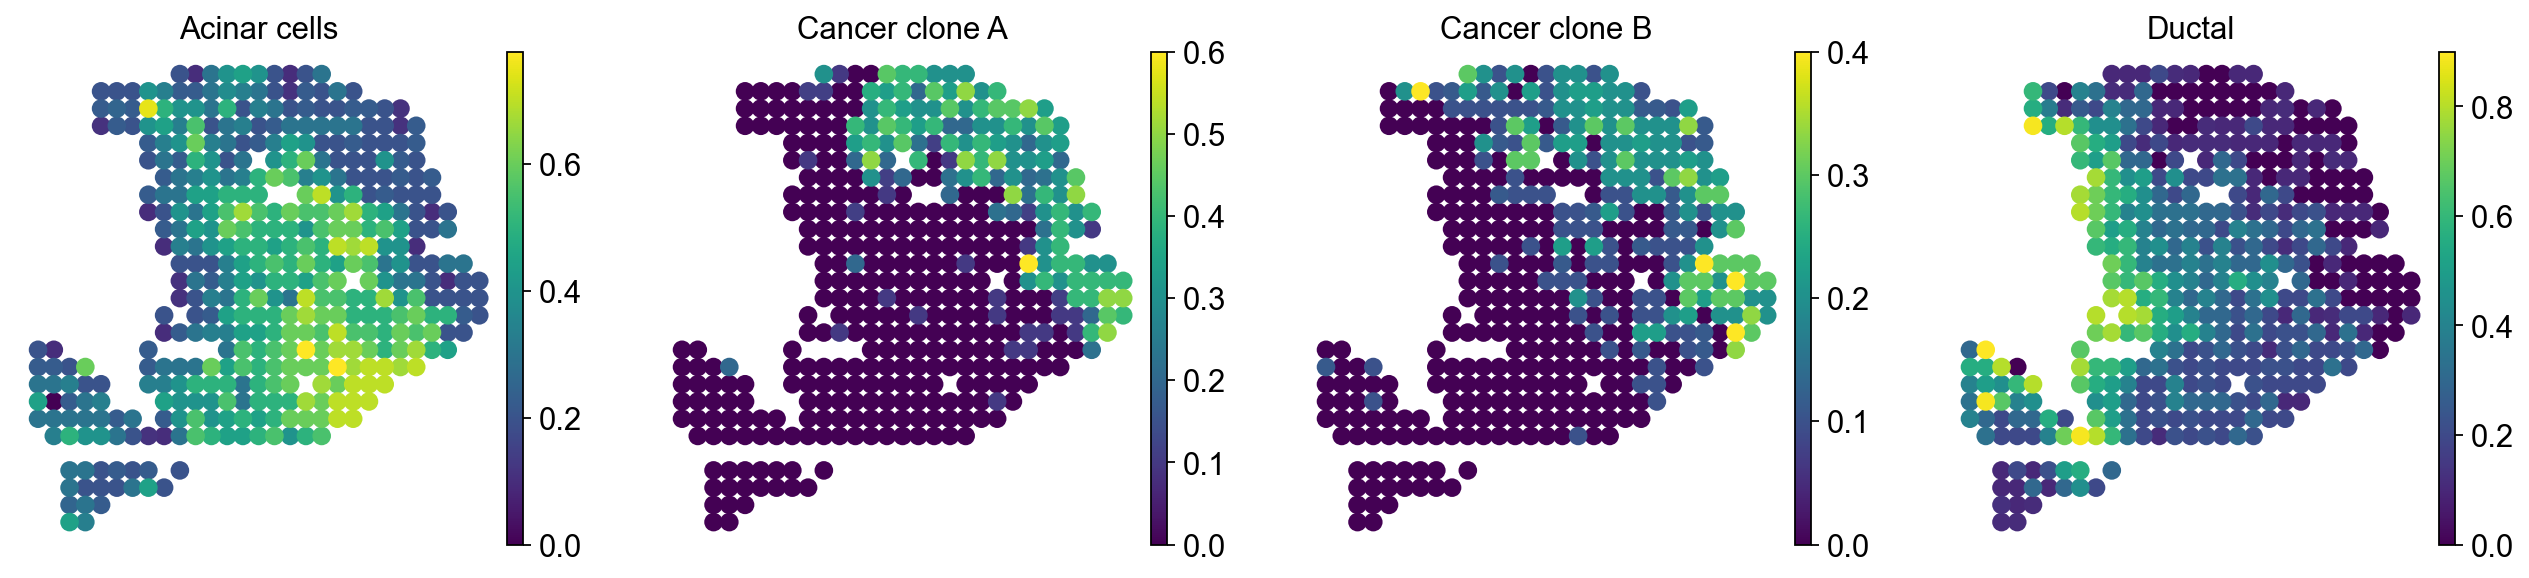

In [11]:
sc.pl.embedding(
    sp_adata_spot,
    basis="X_spatial",
    color=['Acinar cells','Cancer clone A','Cancer clone B','Ductal'],
    frameon=False,
    ncols=4,
    show=False,
    #save='_figure1_celltype_spot.png',
)

<Axes: title={'center': 'Cell_type'}, xlabel='X_spatial1', ylabel='X_spatial2'>

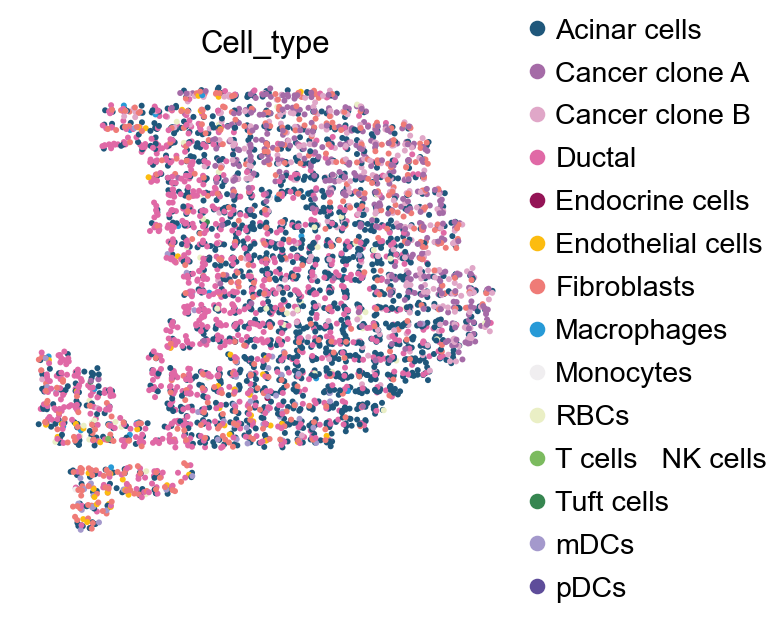

In [13]:
sc.pl.embedding(
    sp_adata,
    basis="X_spatial",
    color=['Cell_type'],
    frameon=False,
    ncols=4,
    show=False,
    # palette=ov.utils.ov_palette()[11:]
)